# Predicting Brain Pathology in Alzheimer's Disease using Elastic Net Regression

The notebook details an analysis using elastic net regression to predict brain pathology score (amyloid, tangles, gpath, and NIA-Reagan scores) in Alzheimer's disease based on clinical features (e.g. cognitive test scores, underlying health conditions, demographic) from last visit before deceased. 

The analysis aims to create a baseline model for future comparisons with lstm model.

# Analysis Steps
- Elastic-Net Regression Used participants' last visit data.
    - Parameter Tuning: GridSearchCV to optimize hyperparameters.
    - Model Fitting: Applied best parameters to fit the elastic net model.
    - Performance Evaluation: Evaluated the model on testing data.

# Set up

In [3]:
import utils
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Load the pickle files
scaled_train_last = pd.read_pickle("scaled_train_last.pkl")
scaled_test_last = pd.read_pickle("scaled_test_last.pkl")

# 1. Perform GLM elastic-net using last visit

## 1.1 Parameter Tuning with GridSearchCV

In [5]:
# Define the parameter grid
param_grid = {
    'alpha': np.logspace(-3, 0, 10).astype(float).round(3),
    'l1_ratio': np.arange(0.0, 0.45, 0.05).astype(float).round(2)
}

# Use the custom model wrapper
elastic_net_ridge_switcher = utils.ElasticNetRidgeSwitcher()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_net_ridge_switcher,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available cores
)

In [8]:
# List of outcomes to loop through
outcomes = ['amyloid', 'gpath', 'tangles', 'niareagansc']

# Define the predictors and the outcomes
drop_vars = ['projid', 'study', 'fu_year', 'cogdx'] + outcomes
train_predictors = scaled_train_last.drop(columns=drop_vars)

# Save grid search results
grid_search_results = {}

for outcome in ['amyloid', 'gpath', 'tangles', 'niareagansc']:
    print(f"Performing grid search for {outcome}")
    
    # Define the target outcome
    train_outcome = scaled_train_last[outcome]
    
    # Fit the grid search
    grid_search.fit(train_predictors, train_outcome)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    # Save results
    grid_search_results[outcome] = {
        "cv_results": cv_results,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
    }

Performing grid search for amyloid
Performing grid search for gpath
Performing grid search for tangles
Performing grid search for niareagansc


## 1.2 Check GridSearchCV results

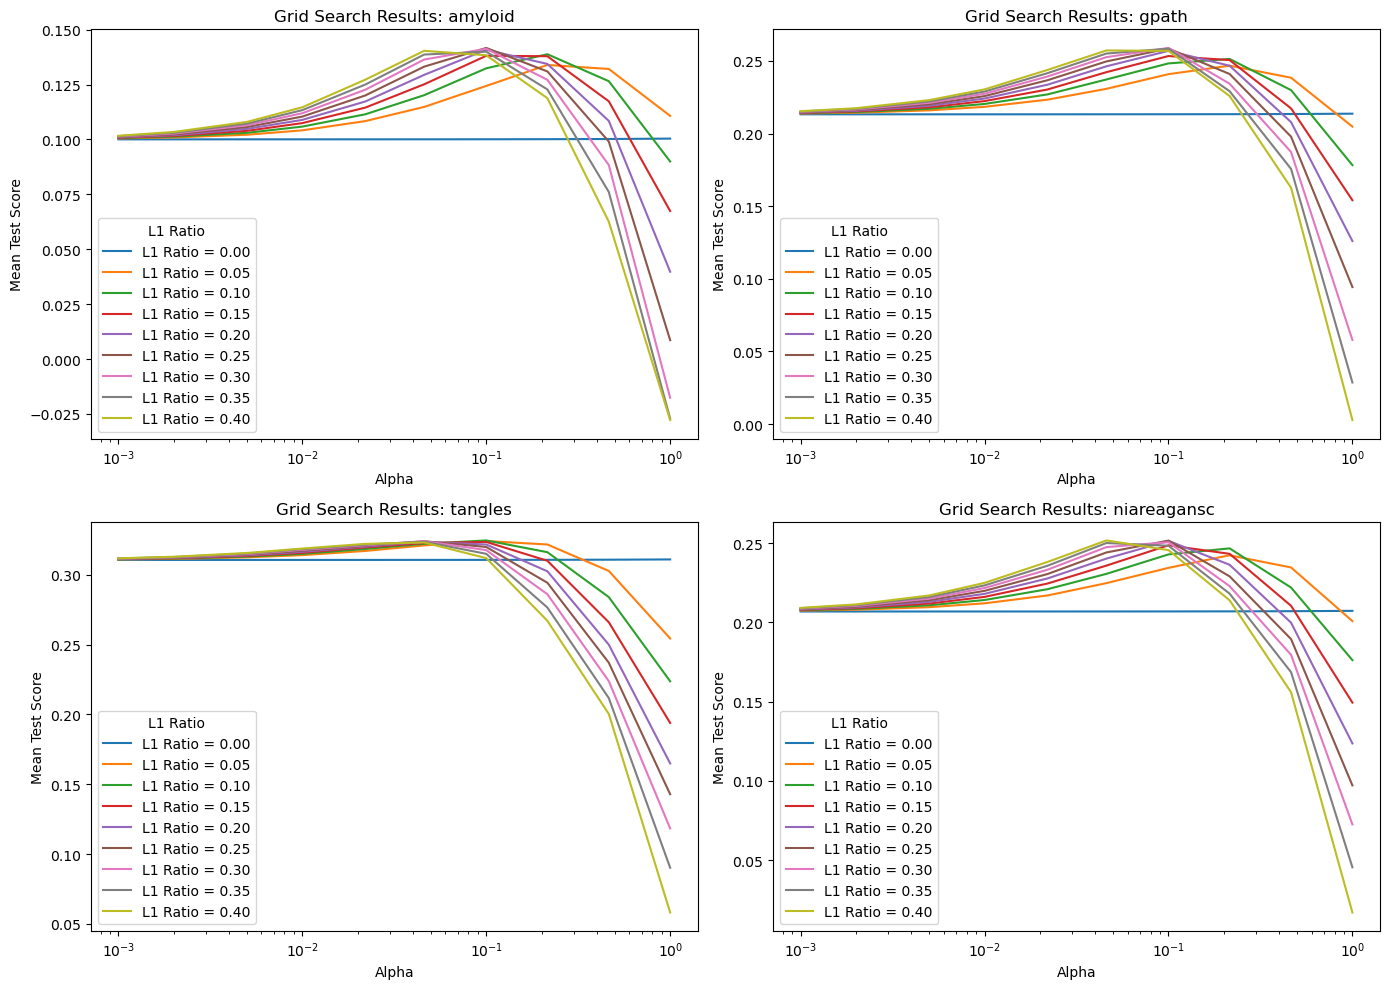

In [ ]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Plot results for each outcome
for idx, outcome in enumerate(['amyloid', 'gpath', 'tangles', 'niareagansc']):
    cv_results = grid_search_results[outcome]["cv_results"]
    ax = axes[idx]
    
    for l1_ratio in cv_results["param_l1_ratio"].unique():
        subset = cv_results[cv_results["param_l1_ratio"] == l1_ratio]
        ax.plot(subset["param_alpha"], subset["mean_test_score"], label=f"L1 Ratio = {l1_ratio:.2f}")
    
    ax.set_xscale("log")
    ax.set_xlabel("Alpha (log scale)")
    ax.set_ylabel("Mean Test Score")
    ax.set_title(f"Grid Search Results: {outcome}")
    ax.legend(title="L1 Ratio")

plt.tight_layout()
plt.show()

## 1.3 Fit model with selected best parameters

In [12]:
# Define test predictors
test_predictors = scaled_test_last.drop(columns=drop_vars)

# Evaluate each outcome
for outcome in ['amyloid', 'gpath', 'tangles', 'niareagansc']:
    print(f"Evaluating {outcome} on test data")
    
    # Define the target outcome
    train_outcome = scaled_train_last[outcome]
    test_outcome = scaled_test_last[outcome]

    # Retrieve best parameters
    best_params = grid_search_results[outcome]["best_params"]

    # Rebuild the model with best parameters
    best_model = utils.ElasticNetRidgeSwitcher(
        alpha=best_params['alpha'],
        l1_ratio=best_params['l1_ratio'],
        max_iter=10000
    )

    # Fit the model on the training data
    best_model.fit(train_predictors, train_outcome)

    # Predict on test data
    y_pred = best_model.predict(test_predictors)

    # Evaluate performance
    r2 = r2_score(test_outcome, y_pred)
    print(f"R-squared on test data for {outcome}: {r2:.4f}")
    print("-" * 50)

Evaluating amyloid on test data
R-squared on test data for amyloid: 0.1539
--------------------------------------------------
Evaluating gpath on test data
R-squared on test data for gpath: 0.2619
--------------------------------------------------
Evaluating tangles on test data
R-squared on test data for tangles: 0.3854
--------------------------------------------------
Evaluating niareagansc on test data
R-squared on test data for niareagansc: 0.3051
--------------------------------------------------


## 3. Perform GLM elastic-net using last visit with PCA to perform dimension reduction

In [20]:
pca = PCA(n_components=2)
components = pca.fit_transform(train_predictors)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Define a threshold for displaying names
threshold = 0.4  # Adjust this value as needed

# Create a dummy DataFrame for scatter plot
dummy_df = pd.DataFrame({'PC1': [0], 'PC2': [0]})  # Placeholder for empty scatter

# Create the scatter plot
fig = px.scatter(dummy_df, x='PC1', y='PC2')  # No actual data points shown

# Add loadings as annotations
for i, feature in enumerate(train_predictors.columns):
    magnitude = np.linalg.norm(loadings[i])  # Calculate the magnitude of the loading
    if magnitude > threshold:  # Only show names for large loadings
        fig.add_annotation(
            ax=0, ay=0,
            axref="x", ayref="y",
            x=loadings[i, 0],
            y=loadings[i, 1],
            showarrow=True,
            arrowsize=2,
            arrowhead=2,
            xanchor="right",
            yanchor="top"
        )
        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature,
            yshift=5,
        )

# Show the plot
fig.show()

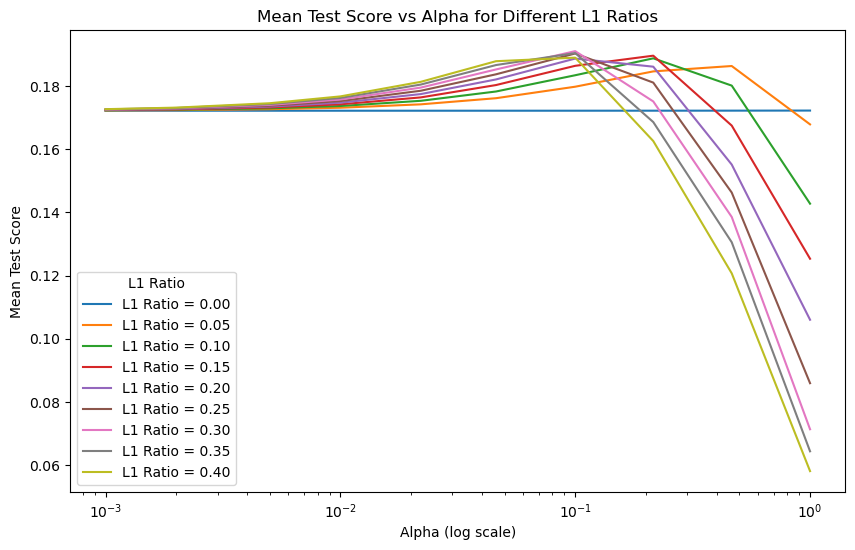

In [21]:
pca = PCA(n_components=20)
train_pcs = pca.fit_transform(train_predictors)

grid_search.fit(train_pcs, gpath_outcome)
cv_results = pd.DataFrame(grid_search.cv_results_)

df = cv_results
plt.figure(figsize=(10, 6))
for l1_ratio in df["param_l1_ratio"].unique():
    subset = df[df["param_l1_ratio"] == l1_ratio]
    plt.plot(subset["param_alpha"], subset["mean_test_score"], label=f"L1 Ratio = {l1_ratio:.2f}")

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Alpha for Different L1 Ratios")
plt.legend(title="L1 Ratio")
plt.show()

In [22]:
best_model = utils.ElasticNetRidgeSwitcher(
    alpha=grid_search.best_params_['alpha'], 
    l1_ratio=grid_search.best_params_['l1_ratio'], 
    max_iter=10000
)

# Fit the model on the entire training data
best_model.fit(train_pcs, gpath_outcome)

# Predict on the test data
test_predictors = scaled_test_last.drop(columns=drop_vars)
test_pcs = pca.transform(test_predictors)
y_pred = best_model.predict(test_pcs)

# Define the target outcome
y_test = scaled_test_last['gpath']

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared on test data: {r2:.4f}")

R-squared on test data: 0.1914
